<a href="https://colab.research.google.com/github/PaulaLuana/deep-learning-exercises/blob/master/projeto_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Projeto CNN-Imagens

Você deverá escolher um problema de classificação de imagens ou algum outro relacionado à visão computacional (que possa ser reslvido com redes CNN convencionais). Para tal, utilize a plataforma Kaggle. Sua solução deve ser apresentada dia da entrega. Você deve submeter um jupyter notebook comentado com a descrição do problema, a descrição do dataset, e a solução. Entrega 11/01/21.

* Divida os dados em treino, validação e teste.
* Escolha duas arquiteturas de redes CNNs pré-treinadas
* Faça o ajuste das redes pré-treinadas usando o conjunto de dados de treino com e sem aumento de dados de duas formas:
1. Congelando as camadas da CNN pre-treinada e ajustando apenas a camada do classificador
2. Ajustando também as camadas da CNN pre-treinada
* Compare os resultados de cada modelo com e sem 
1. Gráficos de acurácia e loss do treinamento e da validação
2. Acurácia no conjunto de teste

## Detecção de máscara em imagens
**Problema:** Criar um algoritmo que possa detectar diretamente se uma pessoa está usando uma máscara facial ou não.<br>
**Dataset do kaggle:** [Face Mask Detection ~12K Images Dataset](https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset)<br>
O daset original contém 5000 imagens para treino de cada categoria, 1000 imagens de teste de cada categoria e 400 imagens para validação de cada categoria. Pensando no quão custoso já é trabalhar com poucas imagens, nesse trabalho usaremos 1000 imagens de treino de cada categoria.

In [ ]:
import os
import keras
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
drive.mount('/drive')

Mounted at /drive


**Divida os dados em treino, validação e teste.**

In [ ]:
import os, shutil, pathlib
original_dir = pathlib.Path("drive/MyDrive/deep-learning/projeto1_cnn/train")
new_base_dir = pathlib.Path("mask_detection")
def make_subset(subset_name, start_index, end_index):
  for category in ("with_mask", "without_mask"):
    dir = new_base_dir / subset_name / category 
    os.makedirs(dir, exist_ok=True)
    fnames = [f"{category}.{i}.png" for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src=original_dir / fname, dst=dir / fname)
make_subset("train", start_index=0, end_index=500)
make_subset("validation", start_index=500, end_index=600)
make_subset("test", start_index=600, end_index=1000)

Gerador

In [ ]:
train_dataset = image_dataset_from_directory(
  new_base_dir / "train",
  image_size=(180, 180),
  batch_size=64)
validation_dataset = image_dataset_from_directory(
  new_base_dir / "validation",
  image_size=(180, 180),
  batch_size=64)
test_dataset = image_dataset_from_directory(
  new_base_dir / "test",
  image_size=(180, 180),
  batch_size=64)

Found 1000 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 800 files belonging to 2 classes.


**Escolha duas arquiteturas de redes CNNs pré-treinadas**

### Arquitetura Vgg16

 Faça o ajuste das redes pré-treinadas usando o conjunto de dados de treino com e sem aumento de dados de duas formas:
1. Congelando as camadas da CNN pre-treinada e ajustando apenas a camada do classificador
2. Ajustando também as camadas da CNN pre-treinada

#### Modelo 1
**Com aumento de dados**, congelando as camadas da CNN pre-treinada e ajustando apenas a camada do classificador

In [ ]:
conv_base = VGG16(
    weights="imagenet",
    include_top=False)

In [ ]:
conv_base.trainable = False #congelando

In [ ]:
data_augmentation = keras.Sequential(
  [
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.2),
  ]
  )

In [ ]:
inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = conv_base(x)
x = layers.Flatten()(x) #Desmembra a matriz em vetores
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x) #Diminui o overfitting apagando alguns pesos
outputs = layers.Dense(1, activation="sigmoid")(x)

In [ ]:
model1 = keras.Model(inputs, outputs)
model1.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
callbacks = [
             keras.callbacks.ModelCheckpoint(
                 filepath="feature_extraction.keras",
                 save_best_only=True,
                 monitor="val_loss"
                 )
]

In [ ]:
history = model1.fit(train_dataset, epochs=5, validation_data=(validation_dataset), callbacks=callbacks)

Epoch 1/5
16/16 [==============================] - 395s 25s/step - loss: 15.7027 - accuracy: 0.8790 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
16/16 [==============================] - 395s 25s/step - loss: 2.4871 - accuracy: 0.9760 - val_loss: 0.2449 - val_accuracy: 0.9950
Epoch 3/5
16/16 [==============================] - 395s 25s/step - loss: 1.0167 - accuracy: 0.9900 - val_loss: 2.0392 - val_accuracy: 0.9850
Epoch 4/5
16/16 [==============================] - 392s 25s/step - loss: 1.7216 - accuracy: 0.9780 - val_loss: 0.9212 - val_accuracy: 0.9950
Epoch 5/5
16/16 [==============================] - 397s 25s/step - loss: 1.3093 - accuracy: 0.9850 - val_loss: 2.8466 - val_accuracy: 0.9800


In [ ]:
test_loss, test_acc = model1.evaluate(test_dataset)

13/13 [==============================] - 261s 20s/step - loss: 1.6509 - accuracy: 0.9700


In [ ]:
accs = []
accs.append(test_acc)
print("Acurácia do conjunto de teste - Modelo 1(Aumento de dados):", test_acc)

Acurácia do conjunto de teste - Modelo 1(Vgg16 - aumento de dados): 0.9700000286102295


#### Modelo 2
Ajuste fino do modelo pré treinado.

In [ ]:
conv_base = VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

In [ ]:
inputs = keras.Input(shape=(180,180,3))
x = conv_base(inputs)
x = layers.Flatten()(x) #Desmembra a matriz em vetores
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x) #Diminui o overfitting apagando alguns pesos
outputs = layers.Dense(1, activation="sigmoid")(x)

In [ ]:
model2 = keras.Model(inputs, outputs)
model2.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
callbacks = [
             keras.callbacks.ModelCheckpoint(
                 filepath="feature_extraction.keras",
                 save_best_only=True,
                 monitor="val_loss"
                 )
]

In [ ]:
history2 = model2.fit(train_dataset, epochs=5, validation_data=(validation_dataset), callbacks=callbacks)

Epoch 1/5
16/16 [==============================] - 459s 29s/step - loss: 18069.5527 - accuracy: 0.5230 - val_loss: 2.7440 - val_accuracy: 0.5350
Epoch 2/5
16/16 [==============================] - 447s 28s/step - loss: 0.8416 - accuracy: 0.5060 - val_loss: 111.0834 - val_accuracy: 0.5000
Epoch 3/5
16/16 [==============================] - 444s 28s/step - loss: 10.7543 - accuracy: 0.4920 - val_loss: 0.6957 - val_accuracy: 0.5000
Epoch 4/5
16/16 [==============================] - 448s 28s/step - loss: 0.6942 - accuracy: 0.5010 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 5/5
16/16 [==============================] - 450s 28s/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6933 - val_accuracy: 0.5000


In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)

13/13 [==============================] - 262s 20s/step - loss: 0.7049 - accuracy: 0.5000


In [ ]:
accs.append(test_acc)
print("Acurácia do conjunto de teste - Modelo 2(Ajuste fino):", test_acc)

Acurácia do conjunto de teste - Modelo 2(Ajuste fino): 0.5


### Arquitetura Xception

A **rede Inception** foi desenvolvida de forma a permitir que múltiplos filtros convoluti-
vos de tamanho diferente possam operar numa mesma profundidade, como se pertencessem
a uma única camada. O módulo Inception tradicional realiza três operações de convolução
diferentes, com filtros 1x1, 3x3 e 5x5, e uma operação max pooling numa mesma entrada
da rede. <br>

Na **rede Xception**, o bloco básico da rede Inception é modificado, de forma a separar
completamentamente o mapeamento de informações entre os canais da entrada, feito por
operações de convolução 1x1, da posterior correlação espacial, realizada por operações
de convolução separadas em cada um dos canais. **A rede é composta por camadas de
convolução separadas em profundidade. Essa operação de convolução separada consiste
em dividir uma convolução tradicional em duas operações distintas.** A primeira aplica um
filtro para cada canal da imagem e a segunda operação aplica uma outro filtro 1x1 entre
todos os canais da imagem de saída da convolução anterior.

**O uso de convoluções separadas reduz o número de parâmetros de aprendizado da
rede sem reduzir a sua capacidade.** Por essa razão, a rede Xception mesmo contendo um
número semelhante de parâmetros que outras redes (cerca de 20 milhões), como a variação
V3 Inception, apresenta um resultado melhor

MOREIRA, Pedro Henrique de Oliveira; ROCHA, Victor Hugo Nascimento; CABRAL, Eduardo Lobo Lustosa. Rede neural convolucional e recursiva para a estimação de profundidade de objetos em vídeos. [S.l: s.n.], 2018.

#### Modelo 1
**Com aumento de dados**, congelando as camadas da CNN pre-treinada e ajustando apenas a camada do classificador

In [ ]:
conv_base = Xception(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False #congelando

83697664/83683744 [==============================] - 0s 0us/step


In [ ]:
data_augmentation = keras.Sequential(
  [
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.2),
  ]
  )

In [ ]:
inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = conv_base(x)
x = layers.Flatten()(x) #Desmembra a matriz em vetores
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x) #Diminui o overfitting apagando alguns pesos
outputs = layers.Dense(1, activation="sigmoid")(x)

In [ ]:
model3 = keras.Model(inputs, outputs)
model3.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
callbacks = [
             keras.callbacks.ModelCheckpoint(
                 filepath="feature_extraction.keras",
                 save_best_only=True,
                 monitor="val_loss"
                 )
]

In [ ]:
history3 = model3.fit(train_dataset, epochs=5, validation_data=(validation_dataset), callbacks=callbacks)

Epoch 1/5
16/16 [==============================] - ETA: 0s - loss: 1135.3669 - accuracy: 0.6580

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


16/16 [==============================] - 149s 9s/step - loss: 1135.3669 - accuracy: 0.6580 - val_loss: 159.4573 - val_accuracy: 0.8750
Epoch 2/5
16/16 [==============================] - 151s 9s/step - loss: 720.3317 - accuracy: 0.7260 - val_loss: 369.2168 - val_accuracy: 0.7850
Epoch 3/5
16/16 [==============================] - 144s 9s/step - loss: 459.3805 - accuracy: 0.7770 - val_loss: 1137.3540 - val_accuracy: 0.6100
Epoch 4/5
16/16 [==============================] - 144s 9s/step - loss: 411.6057 - accuracy: 0.7880 - val_loss: 137.6227 - val_accuracy: 0.8900
Epoch 5/5
16/16 [==============================] - 144s 9s/step - loss: 249.2800 - accuracy: 0.8360 - val_loss: 95.0615 - val_accuracy: 0.9300


In [ ]:
test_loss, test_acc = model3.evaluate(test_dataset)

13/13 [==============================] - 91s 7s/step - loss: 136.6715 - accuracy: 0.8888


In [ ]:
accs.append(test_acc)
print("Acurácia do conjunto de teste - Modelo 1(Aumento de dados):", test_acc)

Acurácia do conjunto de teste - Modelo 1(Aumento de dados): 0.8887500166893005


#### Modelo 2
Ajuste fino do modelo pré treinado.

In [ ]:
conv_base = Xception(
    weights="imagenet",
    include_top=False)
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

In [ ]:
inputs = keras.Input(shape=(180,180,3))
x = conv_base(inputs)
x = layers.Flatten()(x) #Desmembra a matriz em vetores
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x) #Diminui o overfitting apagando alguns pesos
outputs = layers.Dense(1, activation="sigmoid")(x)

In [ ]:
model4 = keras.Model(inputs, outputs)
model4.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
callbacks = [
             keras.callbacks.ModelCheckpoint(
                 filepath="feature_extraction.keras",
                 save_best_only=True,
                 monitor="val_loss"
                 )
]

In [ ]:
history4 = model4.fit(train_dataset, epochs=5, validation_data=(validation_dataset), callbacks=callbacks)

Epoch 1/5
16/16 [==============================] - ETA: 0s - loss: 21.8478 - accuracy: 0.7270

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


16/16 [==============================] - 163s 10s/step - loss: 21.8478 - accuracy: 0.7270 - val_loss: 6.5505 - val_accuracy: 0.8650
Epoch 2/5
16/16 [==============================] - 157s 10s/step - loss: 3.0747 - accuracy: 0.8690 - val_loss: 8.0519 - val_accuracy: 0.7450
Epoch 3/5
16/16 [==============================] - 158s 10s/step - loss: 4.1349 - accuracy: 0.8810 - val_loss: 2.8958 - val_accuracy: 0.9050
Epoch 4/5
16/16 [==============================] - 158s 10s/step - loss: 3.2586 - accuracy: 0.8950 - val_loss: 5.1279 - val_accuracy: 0.7650
Epoch 5/5
16/16 [==============================] - 157s 10s/step - loss: 0.8080 - accuracy: 0.9540 - val_loss: 3.0033 - val_accuracy: 0.8650


In [ ]:
test_loss, test_acc = model4.evaluate(test_dataset)

13/13 [==============================] - 91s 7s/step - loss: 4.3976 - accuracy: 0.8625


In [ ]:
accs.append(test_acc)
print("Acurácia do conjunto de teste - Modelo 2(Ajuste fino):", test_acc)

Acurácia do conjunto de teste - Modelo 2(Ajuste fino): 0.862500011920929


### Comparação de resultados

#### Gráficos de acurácia e loss do treinamento e da validação

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

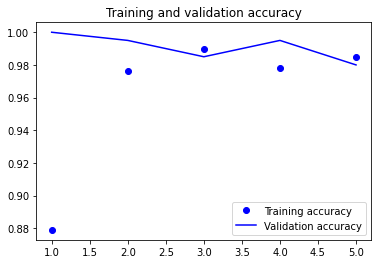

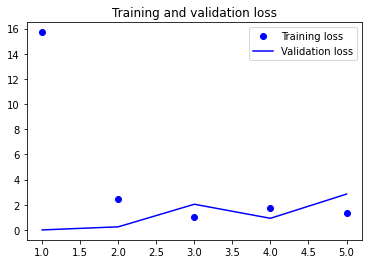

In [ ]:
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
accuracy2 = history2.history["accuracy"]
val_accuracy2 = history2.history["val_accuracy"]
loss2 = history2.history["loss"]
val_loss2 = history2.history["val_loss"]

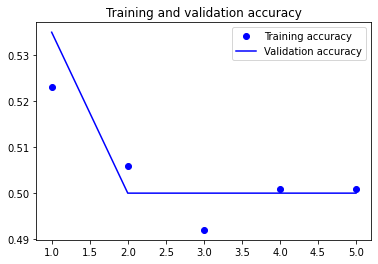

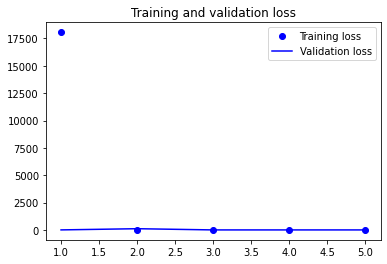

In [ ]:
plt.plot(epochs, accuracy2, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy2, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss2, "bo", label="Training loss")
plt.plot(epochs, val_loss2, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
accuracy3 = history3.history["accuracy"]
val_accuracy3 = history3.history["val_accuracy"]
loss3 = history3.history["loss"]
val_loss3 = history3.history["val_loss"]

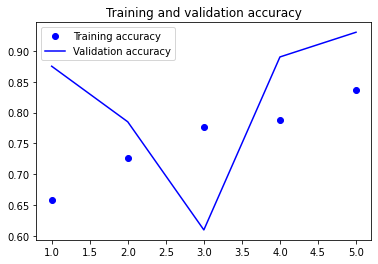

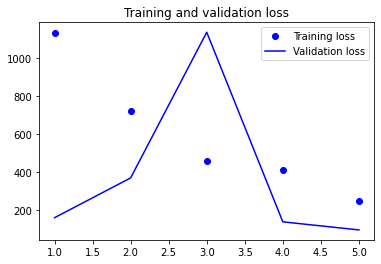

In [ ]:
plt.plot(epochs, accuracy3, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy3, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss3, "bo", label="Training loss")
plt.plot(epochs, val_loss3, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
accuracy4 = history4.history["accuracy"]
val_accuracy4 = history4.history["val_accuracy"]
loss4 = history4.history["loss"]
val_loss4 = history4.history["val_loss"]

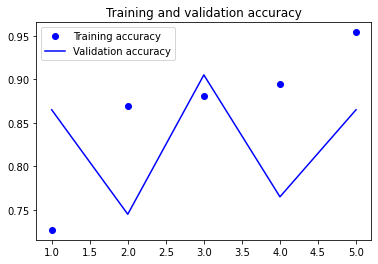

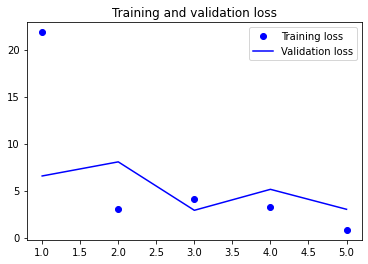

In [ ]:
plt.plot(epochs, accuracy4, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy4, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss4, "bo", label="Training loss")
plt.plot(epochs, val_loss4, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Acurácia do conjunto de teste

In [ ]:
labels = ["Vgg16 - Aumento dos dados", "Vgg16 - Ajuste fino", "Xcetion - Aumento dos dados", "Xcetion - Ajuste fino"]

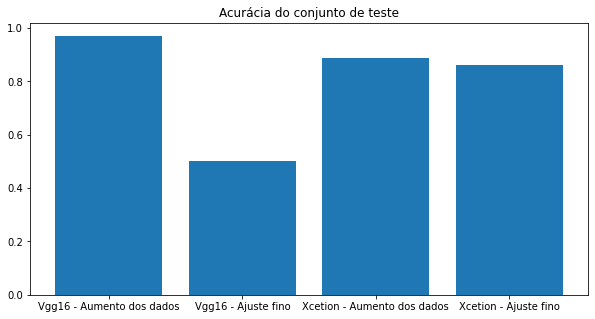

In [ ]:
x = np.arange(len(accs))
plt.subplots(figsize=(10,5))
plt.bar(x, accs, tick_label = labels)
plt.title("Acurácia do conjunto de teste")
plt.show()

https://medium.com/neuronio-br/acelere-seus-projetos-de-deep-learning-com-redes-neurais-pre-treinadas-b5c43bc590e1